# Funghi Classification v3


Usefull imports, try to keep all of them here and labeled!

In [3]:
''' Linear Algebra'''
import pandas as pd
import numpy as np

''' Data visualization'''
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

''' Scikit-Learn'''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix

''' Imbalanced Classes'''
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

''' Tensorflow Keras'''
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import preprocess_input


'''Image loading I believe'''
from tqdm import tqdm
from PIL import Image

Don't forget to enable GPU acceleration!

`Runtime` $\rightarrow$ `Change runtime type` $\rightarrow$ `Hardware accelerator` $\rightarrow$ `GPU`

Mount your google drive!

In [4]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/drive')
# Put Colab in the context of this challenge
import os
# os.chdir allows you to change directories, like cd in the Terminal
my_drive_path="/Colab Notebooks/data-transfer-learning"  #Change accordingly to the path of your project folder
os.chdir('/content/drive/MyDrive'+my_drive_path) 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## (1) Dataset Loading

In [5]:

!pwd #Check path of your mounted drive

/content/drive/MyDrive/Colab Notebooks/data-transfer-learning


In [6]:
!ls #List the contents of the directory you are in

AGAR_examples_200_per_class  flowers-dataset.zip.1  transfer_learning.ipynb
flowers			     funghi
flowers-dataset.zip	     README.md


In [7]:
def load_data(classes_input, data_path_input):

    data_path =data_path_input 
    classes = classes_input 
    imgs = []
    labels = []
    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.find('.jpg')>0]
        for img in tqdm(images_path[:300]):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                image = image.resize((256, 256))
                imgs.append(np.array(image))
                labels.append(i)

    X = np.array(imgs)
    num_classes = len(set(labels))
    y = to_categorical(labels, num_classes)

    # Finally we shuffle:
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    first_split = int(len(imgs) /6.)
    second_split = first_split + int(len(imgs) * 0.2)
    X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

Use the following method to create 
`X_train, y_train, X_val, y_val, X_test, y_test, num_classes` depending on the `classes & path` you want to use:

In [8]:
# CALL load_data with your preferred PATH and LABELS here  JPG
classes_input= {'Achaetomium strumarium':0,
                'Bipolaris australiensis':1,
                'Colletotrichum gloeosporioides':2}

data_path_input = '/content/drive/My Drive/Colab Notebooks/data-transfer-learning/funghi'
X_train, y_train, X_val, y_val, X_test, y_test, num_classes=load_data(classes_input, data_path_input)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


ValueError: ignored

In [9]:
# CALL load_data with your preferred PATH and LABELS here
classes_input= {'B.subtilis':0,
                'C.albicans':1,
                'E.coli':2}

data_path_input = '/content/drive/My Drive/Colab Notebooks/data-transfer-learning/AGAR_examples_200_per_class'
X_train, y_train, X_val, y_val, X_test, y_test, num_classes=load_data(classes_input, data_path_input)

100%|██████████| 200/200 [01:08<00:00,  2.94it/s]


## (2) Visualizing dataset


In [12]:
print("Train_shape: ",X_train.shape,y_train.shape)
print("Val_shape: ",X_val.shape, y_val.shape)
print("Test_shape: ",X_test.shape,y_test.shape)
print("Num_classes: ",num_classes)

Train_shape:  (380, 256, 256, 3) (380, 3)
Val_shape:  (120, 256, 256, 3) (120, 3)
Test_shape:  (100, 256, 256, 3) (100, 3)
Num_classes:  3


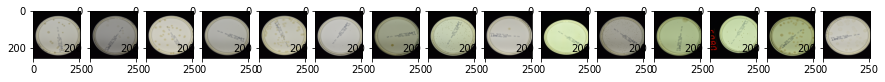

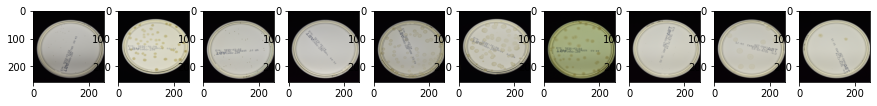

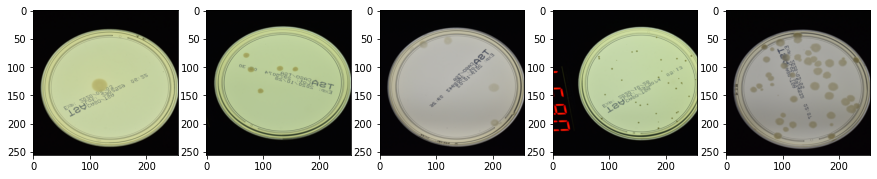

In [14]:
# Visualization order of rows: Training, Validating, Testing data
#ATTENTION: WE MUST REDUCE WHEN WE HAVE MORE DATA
plt.figure(figsize=(15,5))
for i in range(15):
    plt.subplot(1,15, i+1)
    img = X_train[i]
    plt.imshow(img)
plt.figure(figsize=(15,5))
for i in range(10):
    plt.subplot(1,10, i+1)
    img = X_val[i]
    plt.imshow(img)
plt.figure(figsize=(15,5))
for i in range(5):
    plt.subplot(1,5, i+1)
    img = X_test[i]
    plt.imshow(img)

## (3) Data Augmentation (TESTING)

❓ Question: Should we create a cycle that keeps using the augmented data to create even more augmented data, or simply augment from the same X_train every time?
❓

First we create our image generating model and train it on our X_train.

In [ ]:
datagen = ImageDataGenerator(
    #featurewise_center = False,
    #featurewise_std_normalization = False,
    #rotation_range = 10,
    width_shift_range = 100,
    height_shift_range = 100,
    horizontal_flip = True,
    #zoom_range = (0.8, 1.2),
    ) 
datagen.fit(X_train)
datagen

Then we create our augmented data.

In [ ]:
X_augmented_iterator = datagen.flow(X_train, shuffle=False, batch_size=1)
#print(X_train[0].shape)
#print(X_train[0][0].shape)
#print(X_augmented_iterator[0].shape)
#print(X_augmented_iterator[0][0].shape)

Plotting our data next to our augmented data.
`Comments below are simply tests to actually expand the data. As of now, expanded data is not in use`

In [ ]:
#X_train_2 = np.concatenate((X_train, X_augmented_iterator[0]))

#for i in range(1,16):
  #X_train_2 = np.concatenate((X_train_2, X_augmented_iterator[i]))
X_augmented_iterator_2 = datagen.flow(X_train, shuffle=False, batch_size=1)#X_train_2
import numpy as np
counter=0

for i, (raw_image, augmented_image) in enumerate(zip(X_train, X_augmented_iterator)): #X_train_2 X_augmented_iterator_2
    counter=counter+1
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))
    ax1.imshow((raw_image).astype(np.uint8))
    ax2.imshow((augmented_image[0]).astype(np.uint8))
    plt.show()
counter

## (4) Using a pre-trained CNN = Transfer learning

### (4.1) Load VGG16 model

Have a look at the documentation 📚  [tf/keras/applications/VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16)📚


First we create a function to load the model:

In [15]:
def load_model():
    
    model=VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(256,256,3),
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
    )
    
    return model

Then we create a second function to lock the trainability of the layers we want to remain untouched:

In [16]:
def set_nontrainable_layers(model):
    model.trainable=False
    return model

At last we sequentialize all the previous steps with our custom layers (highlighted with comments):

In [17]:
def final_architecture():
    base_model = load_model()
    base_model = set_nontrainable_layers(base_model)

    #############
    flattening_layer = layers.Flatten()
    dense_layer = layers.Dense(50, activation='relu')
    prediction_layer = layers.Dense(num_classes, activation='softmax')#don't edit this one, only layers above it
    #############

    model = Sequential([
      base_model,
      flattening_layer,
      dense_layer,
      prediction_layer
    ])
    return model

Visualize the parameters of our final architecture:

In [18]:
model=final_architecture()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 50)                1638450   
                                                                 
 dense_1 (Dense)             (None, 3)                 153       
                                                                 
Total params: 16,353,291
Trainable params: 1,638,603
Non-trainable params: 14,714,688
_________________________________________________________________


We finalize our module with a custom made compilation function.
❓ Question: Could Adam be the best optimizer? Should other metrics be tested?
❓

In [19]:
def build_model():
    model_compiled=final_architecture()

    opt=Adam(
    learning_rate=1e-4
    )

    model_compiled.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    return model_compiled

### (5.2) VGG Preprocessing (preparation to use fit our data)

In [20]:
X_train_end = preprocess_input(X_train)#X_train_2
X_val_end = preprocess_input(X_val)
X_test_end = preprocess_input(X_test)
#X_train_end.shape

### (5.3)  EUREKA, we can fit the model

In [ ]:
model_final=build_model()

es = EarlyStopping(
    patience=10,
    monitor='val_accuracy', # We really want to dete
    restore_best_weights=True)

history=model_final.fit(X_train_end, y_train,
          epochs=100,  # Use early stopping in practice
          validation_data=(X_val_end, y_val),
          batch_size=64, 
          verbose=1,
         callbacks=[es])

Epoch 1/100
5/6 [========================>.....] - ETA: 46s - loss: 5.1334 - accuracy: 0.3594 

Plot the accuracy for both the train set and and the validation set using the usual function below

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [ ]:
plot_history(history)

Question: Evaluating the model


In [ ]:
print(model_final.evaluate(X_test_end, y_test, verbose=1))
history.__dict__

## (6) (Optional) Improve the model

Now, you can try to improve the model's test accuracy. To do that, here are some options you can consider

1. **Unfreeze and finetune**: Source: [Google tutorial](https://www.tensorflow.org/guide/keras/transfer_learning#fine-tuning) 
>_Once your model has converged on the new data, you can try to unfreeze all or part of the base model and retrain the whole model end-to-end with a very low learning rate. This is an optional last step that can potentially give you incremental improvements. It could also potentially lead to quick overfitting -- keep that in mind. It is critical to only do this step after the model with frozen layers has been trained to convergence. If you mix randomly-initialized trainable layers with trainable layers that hold pre-trained features, the randomly-initialized layers will cause very large gradient updates during training, which will destroy your pre-trained features. It's also critical to use a very low learning rate at this stage, because you are training a much larger model than in the first round of training, on a dataset that is typically very small. As a result, you are at risk of overfitting very quickly if you apply large weight updates. Here, you only want to readapt the pretrained weights in an incremental way._


1. Add **Data Augmentation** if your model is overfitting. 

2. If your model is not overfitting, try a more complex model.

3. Perform a precise **Grid Search** on all the hyper-parameters: learning_rate, batch_size, data augmentation etc...

4. **Change the base model** to more modern one CNN (ResNet, EfficientNet1,... available in the keras library)

5. Curate the data: maintaining a sane data set is one of the keys to success.

6. Collect more data

## (6.2) Comparing the performances of the CNN, the VGG, and the VGG trained on the augmented dataset

In [ ]:
test_accuracy_aug = res_aug[-1]


print(f"test_accuracy_aug = {round(test_accuracy_aug,2)*100} %")

print(f"test_accuracy_vgg = {round(test_accuracy_vgg,2)*100} %")

print(f"test_accuracy = {round(test_accuracy,2)*100} %")

print(f'Chance level: {1./num_classes*100:.1f}%')



---

🏁 **Congratulations** 🏁 

1. Download this notebook from your `Google Drive` or directly from `Google Colab` 
2. Drag-and-drop it from your `Downloads` folder to your local challenge folder  


💾 Don't forget to push your code

3. Follow the usual procedure on your terminal inside the challenge folder:
      * *git add cifar_classification.ipynb*
      * *git commit -m "I am the god of Transfer Learning"*
      * *git push origin master*

*Hint*: To find where this Colab notebook has been saved, click on `File` $\rightarrow$ `Locate in Drive`.

🚀 If you have time, move on to the **Autoencoders** challenge!